In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
image_array = ski.io.imread("N204_S14_Large_SOX2.ome.tiff.png")

In [ ]:
image_array = np.memmap('',dtype=***,mode=R+, shape=)

In [3]:
image_array.shape
#RGBA = Red Green Blue Opacity

(2920, 3392, 4)

In [4]:
rgbimage = ski.color.rgba2rgb(image_array)
bwimage = ski.color.rgb2gray(rgbimage)

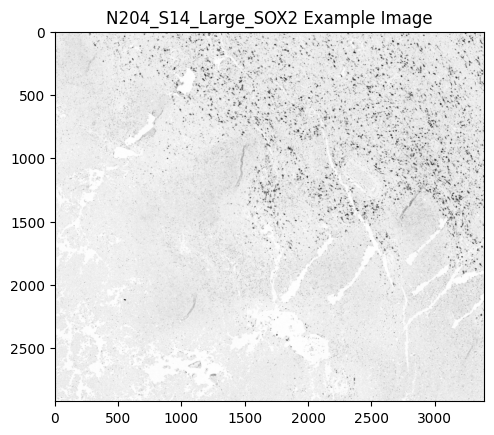

In [5]:
fig, ax = plt.subplots()
ax.imshow(bwimage, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

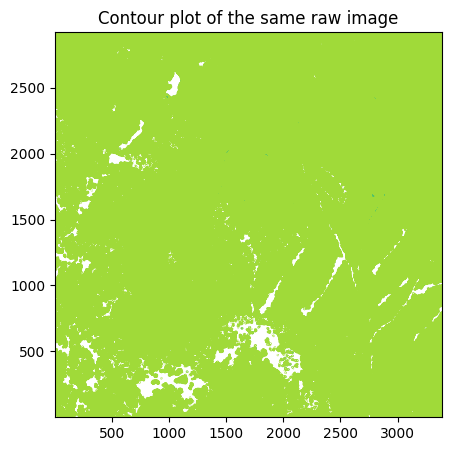

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
qcs = ax.contour(bwimage, origin='image')
ax.set_title('Contour plot of the same raw image')
plt.show()

In [13]:
qcs.levels

array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05])

In [14]:
# Levels without segments still contain one empty array, account for that
[len(seg) if seg[0].size else 0 for seg in qcs.allsegs]

[0, 565, 2310, 3873, 7727, 19296, 154040, 0]

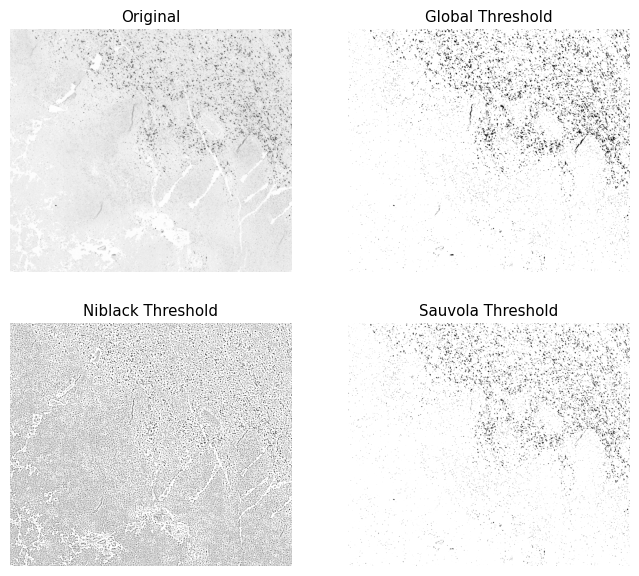

In [7]:
matplotlib.rcParams['font.size'] = 9


image = bwimage
binary_global = image > ski.filters.threshold_otsu(image)

window_size = 25
thresh_niblack = ski.filters.threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = ski.filters.threshold_sauvola(image, window_size=window_size)
thresh_yen = ski.filters.threshold_yen(image)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola
binary_yen = image > thresh_yen

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

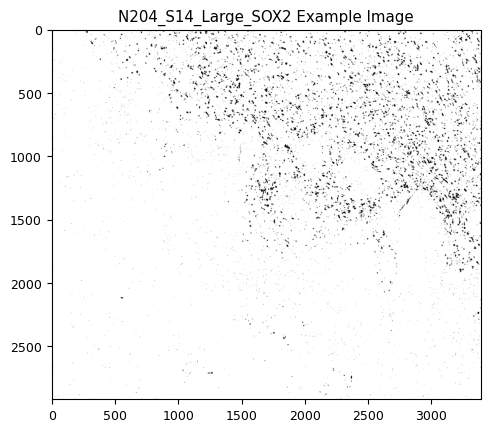

In [29]:
fig, ax = plt.subplots()
ax.imshow(binary_yen, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


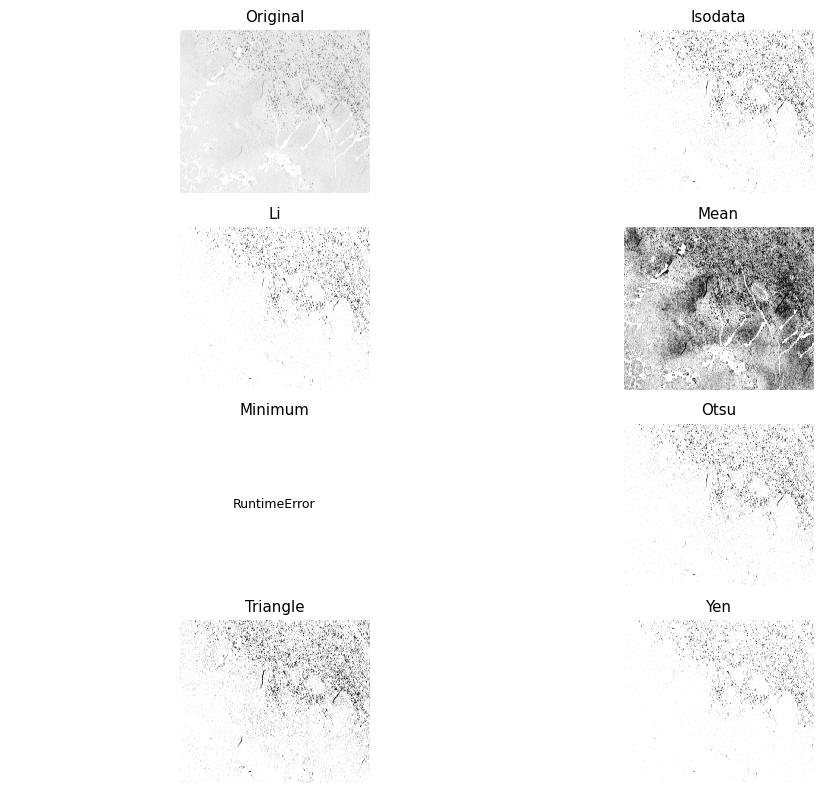

In [24]:
from skimage.filters import try_all_threshold

img = bwimage

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=True)
plt.show()

In [34]:
bwimage.shape

(2920, 3392)

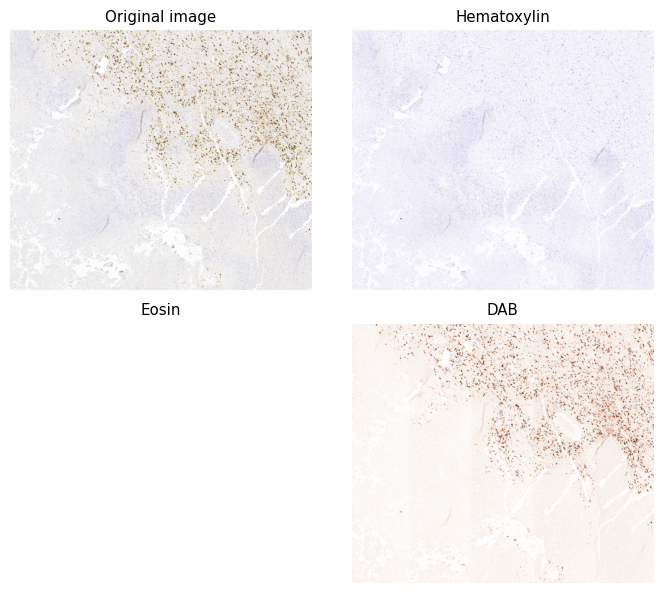

In [20]:
from skimage import data
from skimage.color import rgb2hed, hed2rgb

# Example IHC image
ihc_rgb = rgbimage

# Separate the stains from the IHC image
ihc_hed = rgb2hed(ihc_rgb)

# Create an RGB image for each of the stains
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [22]:
ihc_h.shape

(2920, 3392, 3)

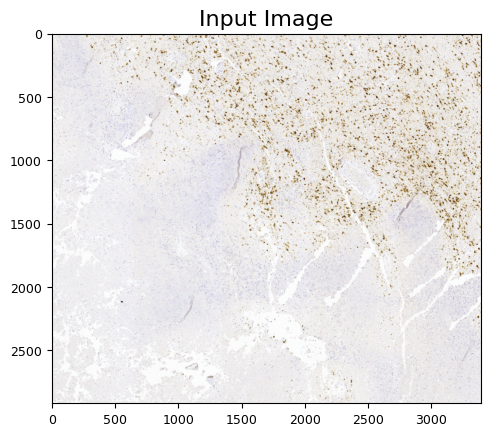

In [12]:
im_input = rgbimage

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

In [18]:
ihc_d.shape

(2920, 3392, 3)

/var/folders/y7/4f15qg1n0tj7wz2vj7y9rc1jrwjr4p/T/ipykernel_25858/42572821.py:19: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(


Number of nuclei =  4739


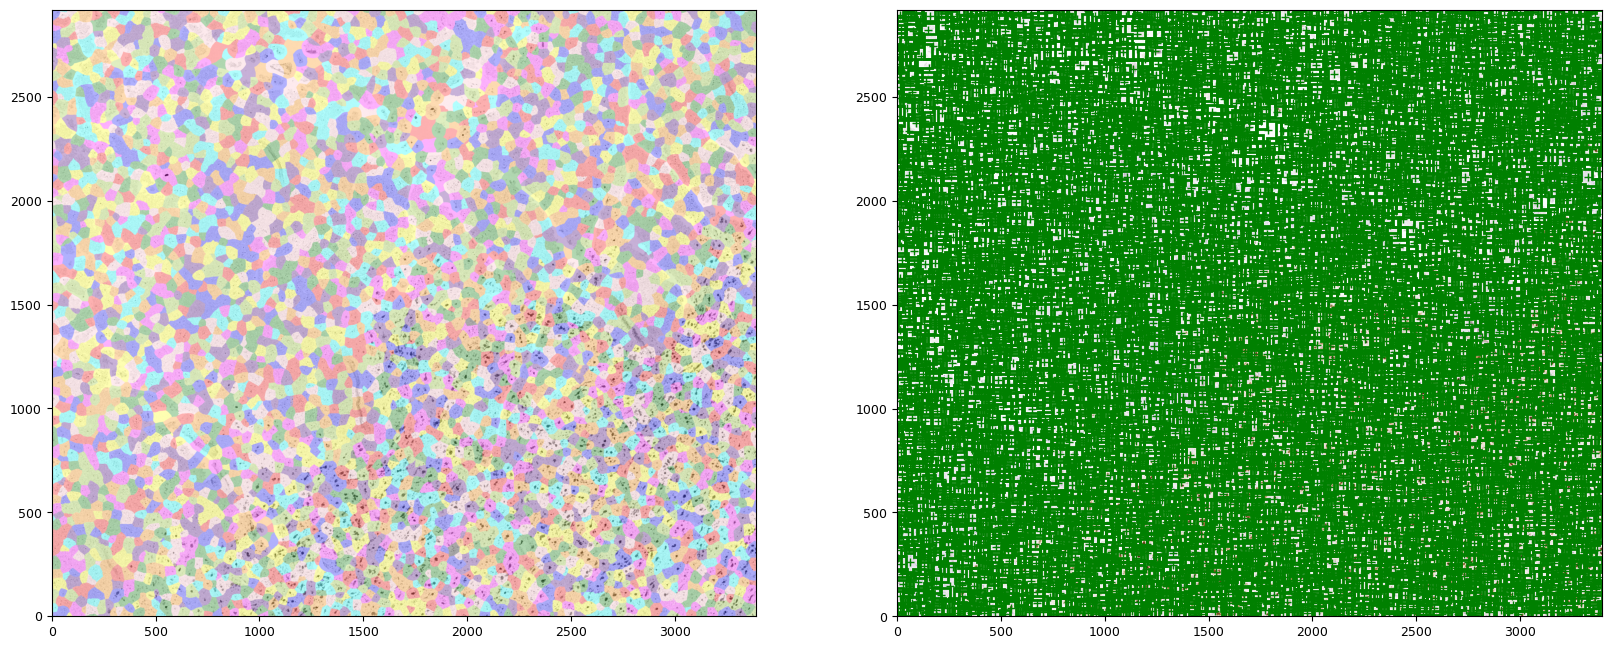

In [24]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# get nuclei/hematoxylin channel
im_nuclei_stain = skimage.color.rgb2gray(ihc_h)

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 8
max_radius = 12

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2),
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int32)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print('Number of nuclei = ', len(objProps))

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, ihc_rgb, bg_label=0), origin='lower')

plt.subplot(1, 2, 2)
plt.imshow( ihc_rgb )
plt.xlim([0, ihc_rgb.shape[1]])
plt.ylim([0, ihc_rgb.shape[0]])

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        'type':        'rectangle',
        'center':      c,
        'width':       width,
        'height':      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

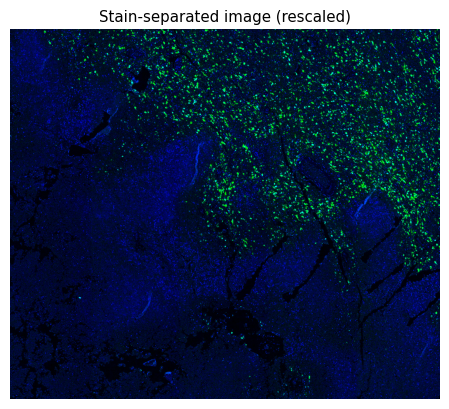

In [31]:
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB channels and give them a fluorescence look
h = rescale_intensity(
    ihc_hed[:, :, 0],
    out_range=(0, 1),
    in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)),
)
d = rescale_intensity(
    ihc_hed[:, :, 2],
    out_range=(0, 1),
    in_range=(0, np.percentile(ihc_hed[:, :, 2], 99)),
)

# Cast the two channels into an RGB image, as the blue and green channels
# respectively
zdh = np.dstack((null, d, h))

fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdh)
axis.set_title('Stain-separated image (rescaled)')
axis.axis('off')
plt.show()

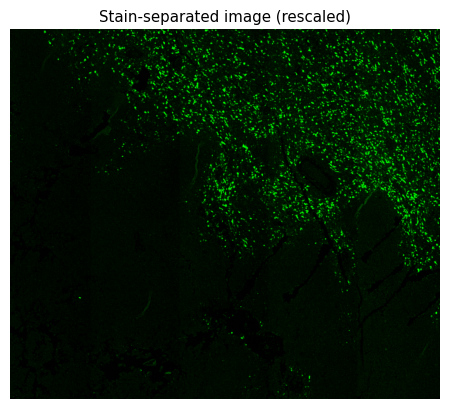

In [32]:
zdz = np.dstack((null, d, null))

fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdz)
axis.set_title('Stain-separated image (rescaled)')
axis.axis('off')
plt.show()

In [33]:
d.shape

(2920, 3392)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


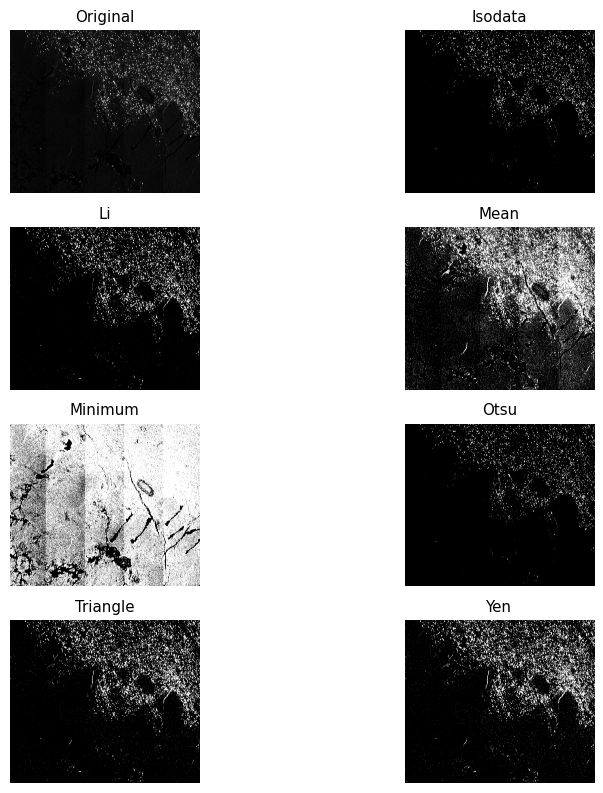

In [35]:
from skimage.filters import try_all_threshold

img = d

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=True)
plt.show()

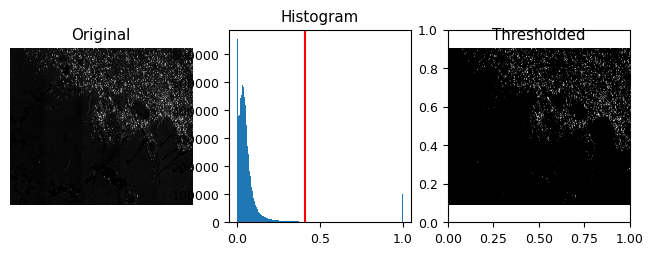

In [39]:
image = d

thresh_yen = ski.filters.threshold_isodata(image)
binary_yen = image > thresh_yen

thresh_otsu = ski.filters.threshold_otsu(image)
binary_otsu = image > thresh_otsu

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh_otsu, color='r')

ax[2].imshow(binary_otsu, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

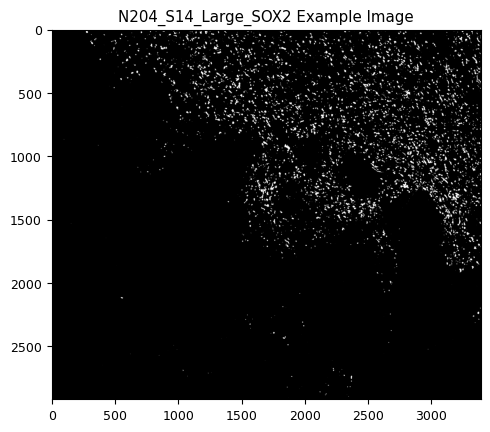

In [40]:
fig, ax = plt.subplots()
ax.imshow(binary_otsu, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

In [64]:
threshold_hema = ski.filters.threshold_niblack(h, window_size=25, k = .8)
binary_nuclei = h < threshold_hema

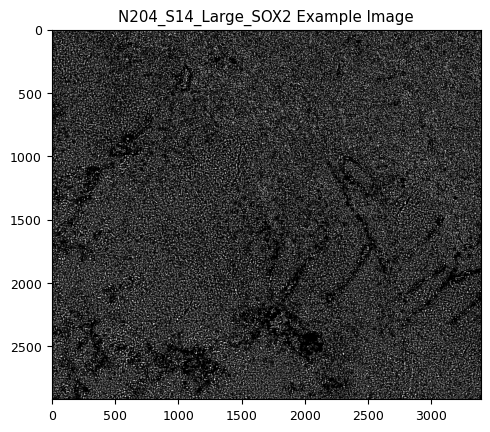

In [65]:
fig, ax = plt.subplots()
ax.imshow(binary_nuclei, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

In [73]:
# Remove small objects and noise
binary_nuclei_edit = ski.morphology.remove_small_objects(binary_nuclei, min_size=50)
binary_otsu_edit = ski.morphology.remove_small_objects(binary_otsu, min_size=50)


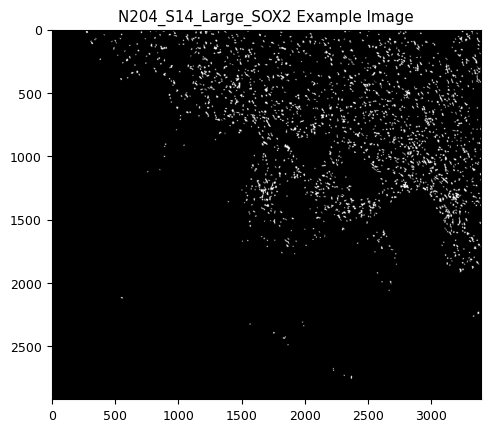

In [74]:
fig, ax = plt.subplots()
ax.imshow(binary_otsu_edit, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

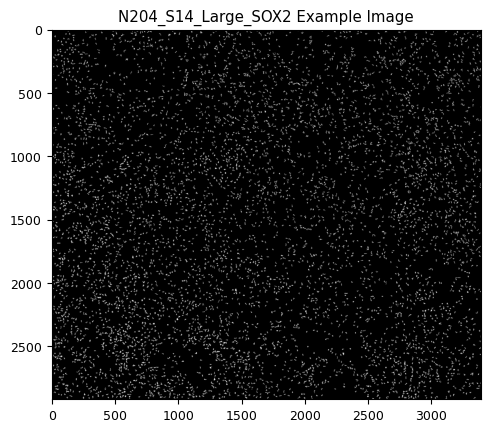

In [75]:
fig, ax = plt.subplots()
ax.imshow(binary_nuclei_edit, cmap='gray')
ax.set_title('N204_S14_Large_SOX2 Example Image')
plt.show()

Total Nuclei Count: 5523
D-Staining Cells Count: 1620
Density (D-staining / Total): 0.29


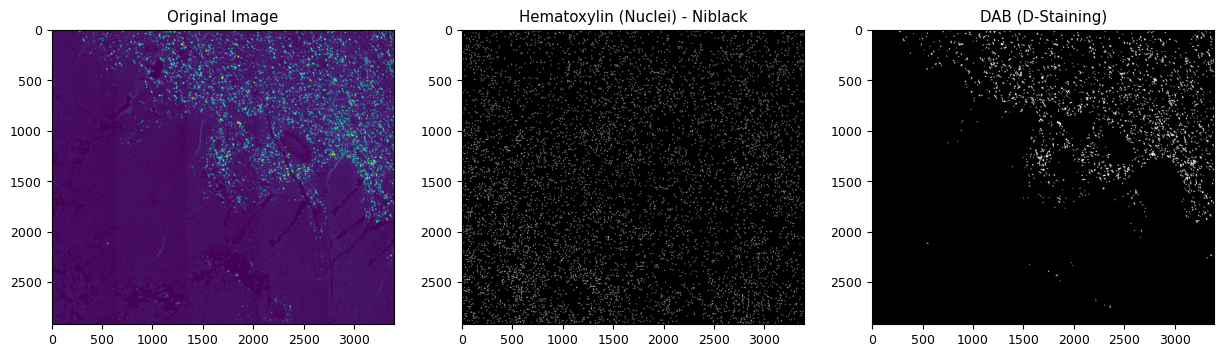

In [76]:
# Label connected components and count
labeled_nuclei = ski.measure.label(binary_nuclei_edit)
labeled_dab = ski.measure.label(binary_otsu_edit)

nuclei_count = np.max(labeled_nuclei)  # Total nuclei
dab_count = np.max(labeled_dab)  # D-staining cells

# Compute density
density = dab_count / nuclei_count if nuclei_count > 0 else 0

# Output results
print(f"Total Nuclei Count: {nuclei_count}")
print(f"D-Staining Cells Count: {dab_count}")
print(f"Density (D-staining / Total): {density:.2f}")

# Visualize
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(binary_nuclei_edit, cmap="gray")
ax[1].set_title("Hematoxylin (Nuclei) - Niblack")
ax[2].imshow(binary_otsu_edit, cmap="gray")
ax[2].set_title("DAB (D-Staining)")
plt.show()

In [77]:
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

# Function to compute density heat map
def compute_density_heatmap(binary_nuclei, binary_dab, downsize_factor=10):
    # Downsample binary masks by summing cells within each block
    nuclei_downsampled = block_reduce(binary_nuclei.astype(int), block_size=(downsize_factor, downsize_factor), func=np.sum)
    dab_downsampled = block_reduce(binary_dab.astype(int), block_size=(downsize_factor, downsize_factor), func=np.sum)
    
    # Avoid division by zero: Set density to zero where there are no nuclei
    with np.errstate(divide='ignore', invalid='ignore'):
        density_heatmap = np.where(nuclei_downsampled > 0, dab_downsampled / nuclei_downsampled, 0)
    
    return density_heatmap

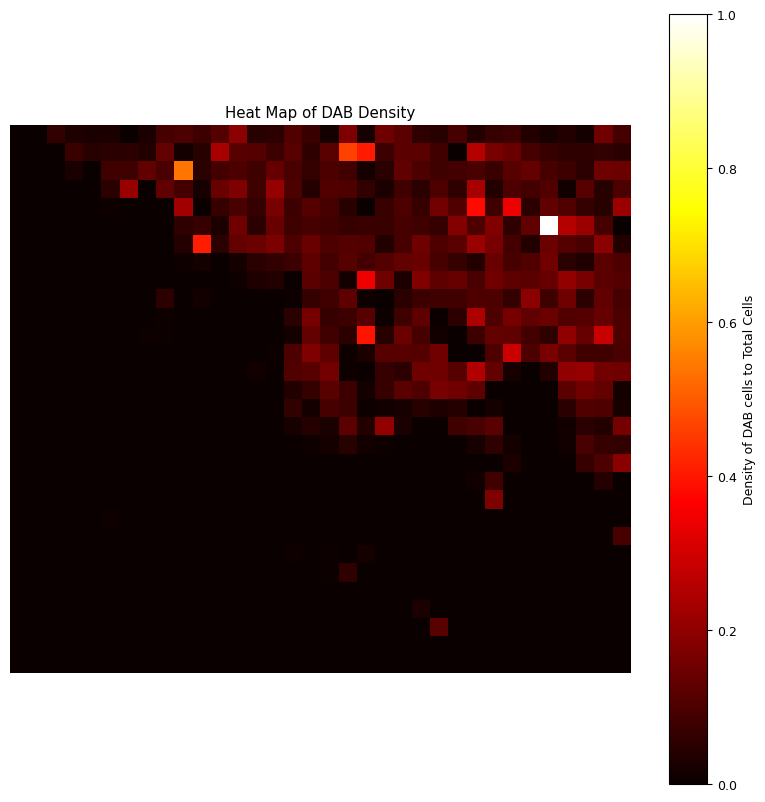

: 

In [80]:
# Compute the heat map
heat_map = compute_density_heatmap(binary_nuclei_edit, binary_otsu_edit, downsize_factor=100)

# Normalize the heat map for better visualization
normalized_heat_map = (heat_map - np.min(heat_map)) / (np.max(heat_map) - np.min(heat_map))

# Visualize the heat map
plt.figure(figsize=(10, 10))
plt.imshow(normalized_heat_map, cmap="hot", interpolation="nearest")
plt.colorbar(label="Density of DAB cells to Total Cells")
plt.title("Heat Map of DAB Density")
plt.axis("off")
plt.show()
